In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/RNN'
! ls

/content/gdrive/MyDrive/RNN
IBM_2006-01-01_to_2018-01-01.csv  recurrent-neural-networks-lstm-gru.ipynb


In [3]:
# Importing the libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, GRU, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error

In [4]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

**Prepare data**

In [5]:
# First, we get the data
dataset = pd.read_csv('../RNN/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [6]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

print('training_set.shape = ', training_set.shape)
print('test_set.shape = ', test_set.shape)

training_set.shape =  (2769, 1)
test_set.shape =  (251, 1)


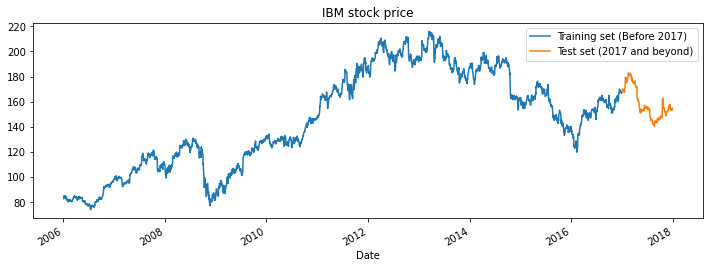

In [7]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(12,4),legend=True)
dataset["High"]['2017':].plot(figsize=(12,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [8]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

print('training_set_scaled.shape = ', training_set_scaled.shape)

training_set_scaled.shape =  (2769, 1)


In [9]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60, 2769):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)

X_train.shape =  (2709, 60)
y_train.shape =  (2709,)


In [10]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print('X_train.shape = ', X_train.shape)

X_train.shape =  (2709, 60, 1)


**1. LSTM model**

In [11]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [12]:
# Compiling the LSTM
regressor.compile(optimizer='adam', loss='mse')
# Fitting to the training set
lstm = regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
85/85 [==============================] - 15s 61ms/step - loss: 0.0218
Epoch 2/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0049
Epoch 3/50
85/85 [==============================] - 5s 61ms/step - loss: 0.0044
Epoch 4/50
85/85 [==============================] - 5s 61ms/step - loss: 0.0040
Epoch 5/50
85/85 [==============================] - 5s 61ms/step - loss: 0.0041
Epoch 6/50
85/85 [==============================] - 5s 61ms/step - loss: 0.0041
Epoch 7/50
85/85 [==============================] - 5s 64ms/step - loss: 0.0036
Epoch 8/50
85/85 [==============================] - 5s 61ms/step - loss: 0.0036
Epoch 9/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0035
Epoch 10/50
85/85 [==============================] - 5s 60ms/step - loss: 0.0028
Epoch 11/50
85/85 [==============================] - 5s 60ms/step - loss: 0.0033
Epoch 12/50
85/85 [==============================] - 5s 60ms/step - loss: 0.0034
Epoch 13/50
85/85 [=================

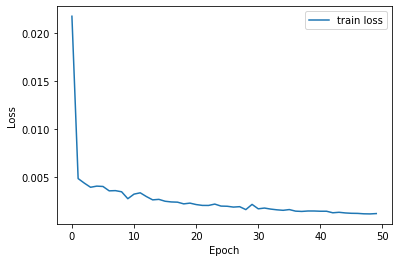

In [13]:
# loss
plt.plot(lstm.history['loss'], label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'], dataset["High"]['2017':]), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - 60:].values
print('dataset_total.shape = ', dataset_total.shape)
print('inputs.shape = ', inputs.shape)

inputs = inputs.reshape(-1,1)
print('inputs.shape = ', inputs.shape)

inputs  = sc.transform(inputs)
print('inputs.shape = ', inputs.shape)

dataset_total.shape =  (3020,)
inputs.shape =  (311,)
inputs.shape =  (311, 1)
inputs.shape =  (311, 1)


In [26]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60, 311):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
print('X_test.shape = ', X_test.shape)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print('X_test.shape = ', X_test.shape)

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print('predicted_stock_price.shape = ', predicted_stock_price.shape)

X_test.shape =  (251, 60)
X_test.shape =  (251, 60, 1)
predicted_stock_price.shape =  (251, 1)


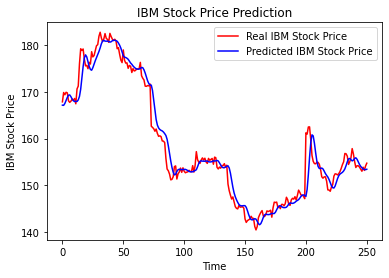

In [27]:
# Visualizing the results for LSTM
plot_predictions(test_set, predicted_stock_price)

In [29]:
# Evaluating our model
return_rmse(test_set, predicted_stock_price)

The root mean squared error is 2.5133931646380647.


**2. GRU model**

In [31]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

regressorGRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 60, 50)            7950      
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_5 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 gru_6 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 gru_7 (GRU)                 (None, 50)               

In [32]:
# Compiling the RNN
#regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
regressorGRU.compile(optimizer='adam', loss='mse')

# Fitting to the training set
gru = regressorGRU.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
85/85 [==============================] - 12s 58ms/step - loss: 0.0255
Epoch 2/50
85/85 [==============================] - 5s 58ms/step - loss: 0.0053
Epoch 3/50
85/85 [==============================] - 5s 59ms/step - loss: 0.0038
Epoch 4/50
85/85 [==============================] - 5s 63ms/step - loss: 0.0037
Epoch 5/50
85/85 [==============================] - 5s 61ms/step - loss: 0.0035
Epoch 6/50
85/85 [==============================] - 5s 58ms/step - loss: 0.0030
Epoch 7/50
85/85 [==============================] - 5s 58ms/step - loss: 0.0034
Epoch 8/50
85/85 [==============================] - 5s 58ms/step - loss: 0.0028
Epoch 9/50
85/85 [==============================] - 5s 57ms/step - loss: 0.0027
Epoch 10/50
85/85 [==============================] - 5s 60ms/step - loss: 0.0025
Epoch 11/50
85/85 [==============================] - 5s 58ms/step - loss: 0.0026
Epoch 12/50
85/85 [==============================] - 5s 57ms/step - loss: 0.0024
Epoch 13/50
85/85 [=================

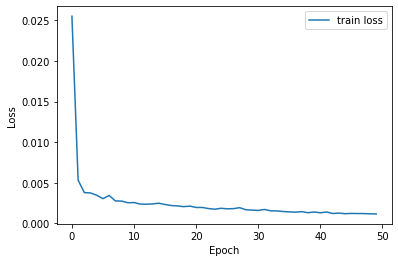

In [33]:
# loss
plt.plot(gru.history['loss'], label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60, 311):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

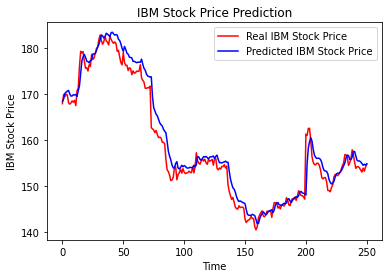

In [37]:
# Visualizing the results for GRU
plot_predictions(test_set, GRU_predicted_stock_price)

In [40]:
# Evaluating GRU
return_rmse(test_set, GRU_predicted_stock_price)

The root mean squared error is 2.3866151703344305.


**Compare predictions made by GRU, LSTM models by plotting data in a single graph**

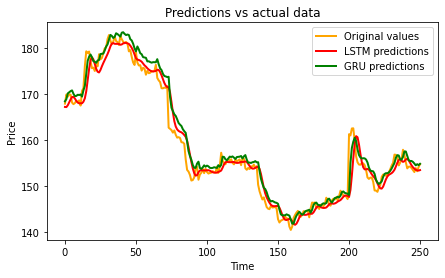

In [42]:
plt.figure(figsize=(7,4))

plt.plot(test_set, c="orange", linewidth=2, label="Original values")
plt.plot(predicted_stock_price, c="red", linewidth=2, label="LSTM predictions")
plt.plot(GRU_predicted_stock_price, c="green", linewidth=2, label="GRU predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=12)
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()